For this 8th tutorial we try to include non-stationary into our GEV parameters to
get a better fit to our sea level heights. First open the data set, and fit a stationary
GEV model to the data by estimating parameters with a MLE method.

Import the data using read.csv() and create a plot of the recorded data. 

In [114]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cartopy.crs as ccrs
from scipy import stats

In [115]:
import extremes_functions as ef
from mystatsfunctions import OLSE,LMoments
import SDFC as sd


In [116]:
gev = stats.genextreme

In [117]:
def estimate_return_level(quantile,model):
    loc, scale, shape = model.coef_
    level = loc - scale / shape * (1 - (-np.log(quantile))**(-shape))
    # level = stats.genextreme.ppf(quantile,-shape,loc=loc,scale=scale)
    return level

In [118]:
def estimate_return_level2(quantile,model):
    loc, scale, shape = model.loc, model.scale, model.shape
    level = loc - scale / shape * (1 - (-np.log(quantile))**(-shape))
    # level = stats.genextreme.ppf(quantile,-shape,loc=loc,scale=scale)
    return level

In [119]:
data = pd.read_csv('WashingtonDCSSH1930-2022.csv',index_col=0).set_index('years')

Text(0, 0.5, 'sea surface height')

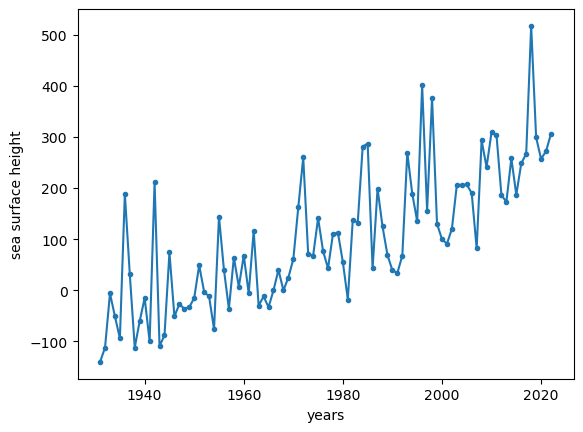

In [120]:
data.ssh.plot(linestyle='-',marker='.')
plt.ylabel('sea surface height')

In [121]:
fit, model = ef.fit_return_levels_sdfc(data.ssh.values,times=np.arange(1.1,1000),periods_per_year=1,kind='GEV',N_boot=1000,full=True,model=True)

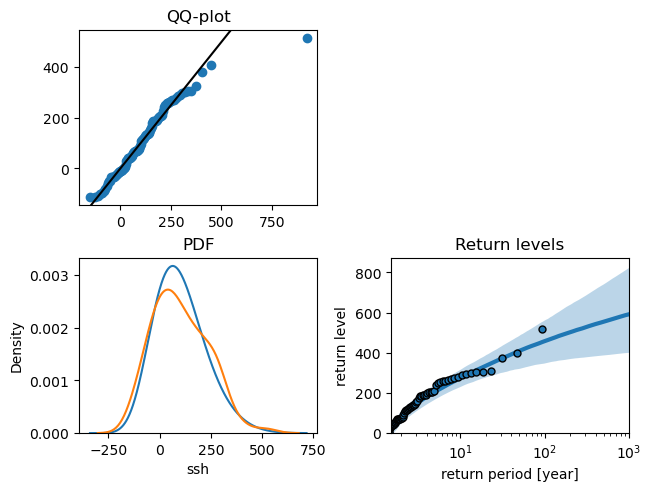

In [122]:
fig, axs = plt.subplots(2,2,constrained_layout=True)
ax = axs.flatten()

x = np.linspace(0,1,100)
ax[0].plot(gev.ppf(x, -fit.xi.mean().values, loc=fit.mu.mean().values, scale=fit.sigma.mean().values), np.quantile(data.ssh,x),'o')
xlim = ax[0].get_xlim()
ylim = ax[0].get_ylim()
ax[0].plot([min(xlim[0],ylim[0]),max(xlim[1],ylim[1])],[min(xlim[0],ylim[0]),max(xlim[1],ylim[1])],'k')

ax[0].set_xlim(xlim)
ax[0].set_ylim(ylim)


x = np.linspace(data.ssh.min()-200, data.ssh.max()+200, 1000)
ax[2].plot(x,gev.pdf(x, -fit.xi.mean().values, loc=fit.mu.mean().values, scale=fit.sigma.mean().values), label='Modeled')
sns.kdeplot(data.ssh,ax=ax[2],label='Empirical')

ef.plot_levels_from_obj(fit,alpha=0.95,ax=ax[3])
ax[3].set_xlim(1.5,1000)
ax[3].set_ylim(0,None)

ax[0].set_title('QQ-plot')
ax[2].set_title('PDF')
ax[3].set_title('Return levels')

ax[1].remove()

(0.0, 874.0657068581708)

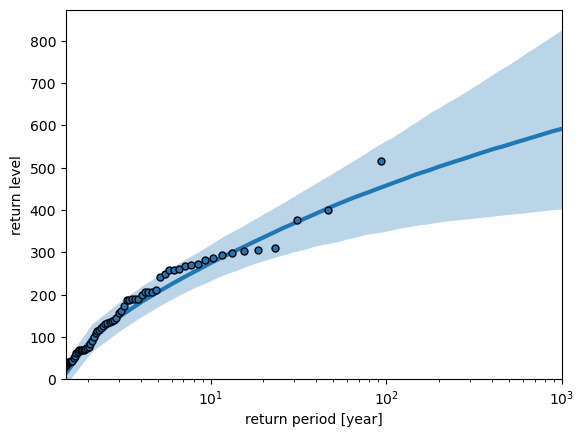

In [123]:
ef.plot_levels_from_obj(fit,alpha=0.95)
plt.xlim(1.5,1000)
plt.ylim(0,None)

In [124]:
print('100-year return level: %.2f' % estimate_return_level(1-1/100,model))

100-year return level: 462.88


we can make our GEV model non-stationary adding a time component to the GEV parameters. 

That means that our parameters change as time changes… Or... we could make them dependent on global air 
temperature for example. The simplest version of a non-stationary GEV model is by adding a linear time
component to the location parameter. Instead of our location parameter being (for example) “100” it would
be a linear function time ( time*1.05+80” ). The location parameter now becomes larger as time increases.
We can easily incorporate this into our fevd() function through the option of location.fun: 


In [125]:
law_ns = sd.GEV()
law_ns.fit(data.ssh.values, c_loc = np.arange(data.index.size))

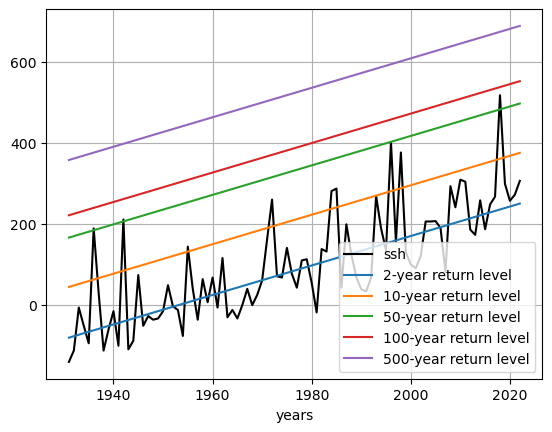

In [126]:
data.ssh.plot(c='k')
plt.plot(data.index,estimate_return_level2(1-1/2,law_ns),label='2-year return level')
plt.plot(data.index,estimate_return_level2(1-1/10,law_ns),label='10-year return level')
plt.plot(data.index,estimate_return_level2(1-1/50,law_ns),label='50-year return level')
plt.plot(data.index,estimate_return_level2(1-1/100,law_ns),label='100-year return level')
plt.plot(data.index,estimate_return_level2(1-1/500,law_ns),label='500-year return level')
plt.legend()
plt.grid(True)

In [127]:
model

+-----------+--------+------------+---------+----------------+----------------+
| GEV (mle) |  Link  |    Type    |  coef   | Quantile 0.025 | Quantile 0.975 |
+===========+========+============+=========+================+================+
| loc       | IdLink | Stationary | 45.247  | 20.185         | 77.027         |
+-----------+--------+------------+---------+----------------+----------------+
| scale     | IdLink | Stationary | 117.009 | 100.109        | 134.067        |
+-----------+--------+------------+---------+----------------+----------------+
| shape     | IdLink | Stationary | -0.115  | -0.326         | 0.013          |
+-----------+--------+------------+---------+----------------+----------------+

In [128]:
law_ns

+-----------+--------+------------+------------------+
| GEV (mle) |  Link  |    Type    |       coef       |
+===========+========+============+==================+
| loc       | IdLink | Covariate  | [-103.002, 3.63] |
+-----------+--------+------------+------------------+
| scale     | IdLink | Stationary | 61.414           |
+-----------+--------+------------+------------------+
| shape     | IdLink | Stationary | 0.059            |
+-----------+--------+------------+------------------+

As you can see we related the location parameter (relate = ~ ) by a vector which is just 1,2,3,4,5,6 etc.
When instead of using 1,2,3,4,etc.; we would use 1,2,4,8,16, etc (exponential growth) we would create a 
location parameter that looks like this: “80*exp(1.05*t)”. You can use all sorts of relations AND you can
apply it to all the parameters (or multiple) through scale.fun and shape.fun. You could also, for example,
related it to CO2 levels instead (if you have those)… which would probably make the fit even better. 

Also… you can assess the fit of your model by looking at the AIC level of your fevd() run. If you run the
fevd() object (in this case fevd or fevd_ns) it should be one of the last lines. The lower the AIC number
the better the fit. Additionally try to make the scale or shape parameter dependent on time by using the 
shape.fun and scale.fun option - or maybe a combination of all.

In [130]:
def compute_aic(model):
    return 2 * len(model.coef_) + 2 * model.info.optim_result.fun

In [131]:
compute_aic(model)

1161.2588604785976

In [132]:
compute_aic(law)

1062.453526638374

### scale as function of time

In [133]:
law_ns_scale = sd.GEV()
law_ns_scale.fit(data.ssh.values, c_scale = np.arange(data.index.size))

Text(0.5, 1.0, 'Scale as function of time')

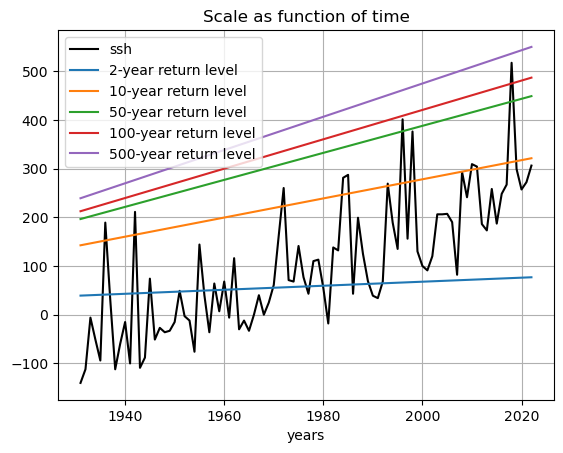

In [134]:

data.ssh.plot(c='k')
plt.plot(data.index,estimate_return_level2(1-1/2,law_ns_scale),label='2-year return level')
plt.plot(data.index,estimate_return_level2(1-1/10,law_ns_scale),label='10-year return level')
plt.plot(data.index,estimate_return_level2(1-1/50,law_ns_scale),label='50-year return level')
plt.plot(data.index,estimate_return_level2(1-1/100,law_ns_scale),label='100-year return level')
plt.plot(data.index,estimate_return_level2(1-1/500,law_ns_scale),label='500-year return level')
plt.legend()
plt.grid(True)
plt.title('Scale as function of time')

### scale as function of time

In [135]:
law_ns_shape = sd.GEV()
law_ns_shape.fit(data.ssh.values, c_shape = np.arange(data.index.size))

Text(0.5, 1.0, 'Shape as function of time')

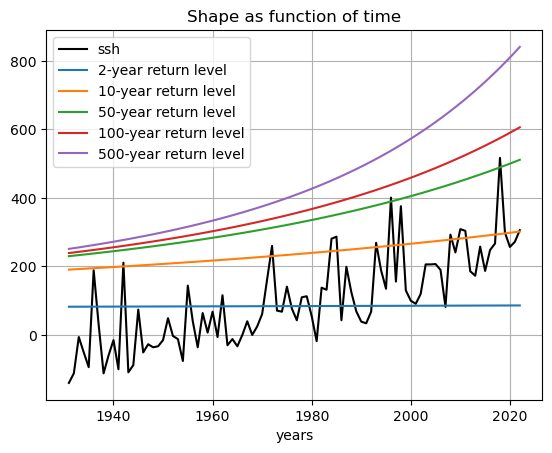

In [136]:

data.ssh.plot(c='k')
plt.plot(data.index,estimate_return_level2(1-1/2,law_ns_shape),label='2-year return level')
plt.plot(data.index,estimate_return_level2(1-1/10,law_ns_shape),label='10-year return level')
plt.plot(data.index,estimate_return_level2(1-1/50,law_ns_shape),label='50-year return level')
plt.plot(data.index,estimate_return_level2(1-1/100,law_ns_shape),label='100-year return level')
plt.plot(data.index,estimate_return_level2(1-1/500,law_ns_shape),label='500-year return level')
plt.legend()
plt.grid(True)
plt.title('Shape as function of time')

### location and scale as function of time

In [137]:
law_ns_loc_scale = sd.GEV()
law_ns_loc_scale.fit(data.ssh.values, c_loc = np.arange(data.index.size), c_scale = np.arange(data.index.size))

Text(0.5, 1.0, 'Location and scale as function of time')

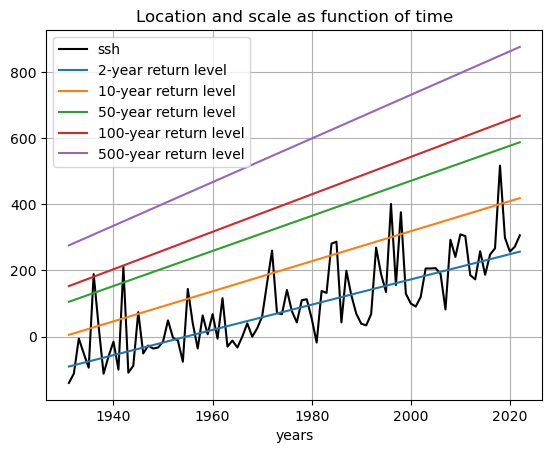

In [138]:

data.ssh.plot(c='k')
plt.plot(data.index,estimate_return_level2(1-1/2,law_ns_loc_scale),label='2-year return level')
plt.plot(data.index,estimate_return_level2(1-1/10,law_ns_loc_scale),label='10-year return level')
plt.plot(data.index,estimate_return_level2(1-1/50,law_ns_loc_scale),label='50-year return level')
plt.plot(data.index,estimate_return_level2(1-1/100,law_ns_loc_scale),label='100-year return level')
plt.plot(data.index,estimate_return_level2(1-1/500,law_ns_loc_scale),label='500-year return level')
plt.legend()
plt.grid(True)
plt.title('Location and scale as function of time')

In [139]:
aics = pd.Series(
    index = ['Location','Scale','Shape','Location and Scale'],
    data  = [compute_aic(law), compute_aic(law_ns_scale), compute_aic(law_ns_shape), compute_aic(law_ns_loc_scale)]
    )

aics

Location              1062.453527
Scale                 1157.801560
Shape                 1161.219576
Location and Scale    1061.982856
dtype: float64

Since the location parameter is not dependent on time we cannot construct a return level/return period
plot like we did last class… As there are now 93 different plots, one for each year. What we can however
do, which is also visually attractive, is compute the level of the 100-year event over time and plot that
onto our SSH record. We call
this the “effective return levels”. 


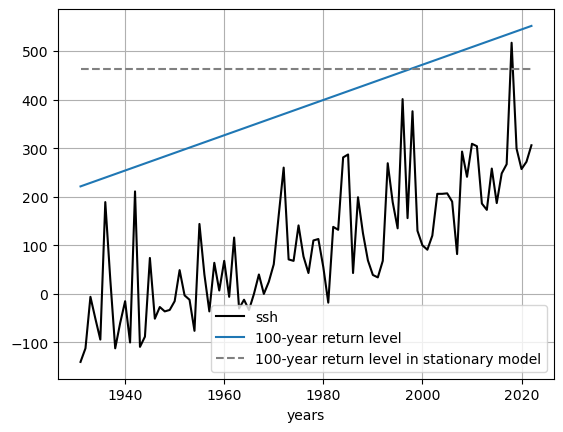

In [113]:
data.ssh.plot(c='k')
# plt.plot(data.index,estimate_return_level2(1-1/2,law),label='2-year return level')
# plt.plot(data.index,estimate_return_level2(1-1/10,law),label='10-year return level')
# plt.plot(data.index,estimate_return_level2(1-1/50,law),label='50-year return level')
plt.plot(data.index,estimate_return_level2(1-1/100,law),label='100-year return level')
# plt.plot(data.index,estimate_return_level2(1-1/500,law),label='500-year return level')

plt.plot(data.index,estimate_return_level2(1-1/100,model),'--',c='grey',label='100-year return level in stationary model')

plt.legend()
plt.grid(True)